# Assignment 4

### 1. 复现代码

In [1]:
import numpy as np
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        for n in self.inputs:
            n.outputs.append(self)
        self.value = None
        self.gradients = {}

    def forward(self):
        raise NotImplemented
    
    def backward(self):
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        if value is not None:
            self.value = value
            
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)

    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
            
class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self): 
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.
            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.

class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])

    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff**2)

    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.
    for n in graph:
        n.forward()
    for n in  graph[::-1]:
        n.backward()

def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]          
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [2]:
from sklearn.datasets import load_boston
data = load_boston()
losses = []

In [3]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 167.948
Epoch: 101, Loss: 9.376
Epoch: 201, Loss: 7.369
Epoch: 301, Loss: 4.556
Epoch: 401, Loss: 4.082
Epoch: 501, Loss: 4.144
Epoch: 601, Loss: 3.926
Epoch: 701, Loss: 3.138
Epoch: 801, Loss: 3.062
Epoch: 901, Loss: 3.225
Epoch: 1001, Loss: 3.383
Epoch: 1101, Loss: 2.991
Epoch: 1201, Loss: 3.101
Epoch: 1301, Loss: 3.528
Epoch: 1401, Loss: 3.376
Epoch: 1501, Loss: 3.131
Epoch: 1601, Loss: 3.204
Epoch: 1701, Loss: 3.464
Epoch: 1801, Loss: 3.068
Epoch: 1901, Loss: 3.097
Epoch: 2001, Loss: 2.833
Epoch: 2101, Loss: 3.009
Epoch: 2201, Loss: 2.621
Epoch: 2301, Loss: 2.531
Epoch: 2401, Loss: 2.752
Epoch: 2501, Loss: 3.175
Epoch: 2601, Loss: 2.999
Epoch: 2701, Loss: 3.053
Epoch: 2801, Loss: 2.977
Epoch: 2901, Loss: 2.777
Epoch: 3001, Loss: 2.572
Epoch: 3101, Loss: 2.694
Epoch: 3201, Loss: 3.162
Epoch: 3301, Loss: 2.512
Epoch: 3401, Loss: 2.725
Epoch: 3501, Loss: 3.015
Epoch: 3601, Loss: 2.702
Epoch: 3701, Loss: 2.688
Epoch: 3801, Loss: 2.900
Epoc

In [4]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value
forward(l2,graph)

array([[49.96264802],
       [45.98761483],
       [49.96264802],
       [26.68424225],
       [35.06504003],
       [12.75159491],
       [22.38803858],
       [20.81659133],
       [23.96138384],
       [23.32035014],
       [12.65783748],
       [14.01510749],
       [35.74037155],
       [34.42588272],
       [23.65810747],
       [19.92409224]])

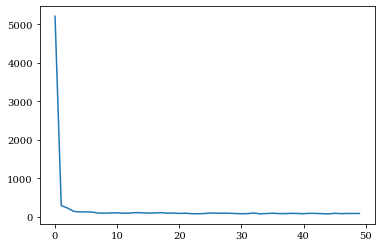

In [6]:
# Loss function
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

Ans: 
1.预测事物发生概率：将输入层的样本与各自的权重相乘，并加上常数，最后通过激活函数，即可作为输出层输出。该输出可以视为所预测事物发生的概率。
2.拟合一个复杂的函数：在样本参数不确定时，通过神经元的正向与反向传播，一次次更新参数，最终可以拟合一个复杂的函数。

####  2. Why we use non-linear activation funcitons in neural networks?

Ans: 线性激活函数会导致单层与多层神经网络效果一样。所以用飞线性激活函数。

#### 3. What is the 'Logistic Loss' ?

Ans: 在机器学习中，通常把模型关于单个样本预测值与真实值的差称为损失，损失越小，模型越好，而用于计算损失的函数称为损失函数。
$$Loss = -(y*log\hat{y} + (1-y)log(1-\hat{y}))$$

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
√C. sigmoid    
D. tanh  
sigmoid取值范围为(0,1)，它可以将一个实数映射到(0,1)的区间，可以用来做二分类。

#### 5. Why we don't use zero initialization for all parameters ?

由于神经网络对称性问题。正向传播会使得每个输出层输出为0；反向传播使得每层梯度为0。换句话说，本来我们希望不同的结点学习到不同的参数，但是由于参数相同以及输出值都一样，不同的结点根本无法学到不同的特征！这样就失去了网络学习特征的意义了。
总结来看：w初始化全为0，很可能直接导致模型失效，无法收敛。

#### 6. Can you implement the softmax function using python ? 

In [478]:
def softmax(x):
    return np.exp(X) / np.sum(np.exp(X))

### 3.实践题

In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .¶


### 3.0 Implement a two-layer neural network to predict picture categories and evaluate using cross-entropy

#### 0 - Realize classes contains which can be used to build neural networks

In [570]:
import numpy as np
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        for n in self.inputs:
            n.outputs.append(self)
        self.value = None
        self.gradients = {}

    def forward(self):
        raise NotImplemented
    
    def backward(self):
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        if value is not None:
            self.value = value
            
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)

    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
            
class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self): 
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.
            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.

class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])

    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff**2)

    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.
    for n in graph:
        n.forward()
    for n in  graph[::-1]:
        n.backward()

def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]          
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [571]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as n

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as 0 if the digit < 5 or 1 if the digit >= 5
    - each image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [572]:
# Loading the data 
digits = datasets.load_digits()

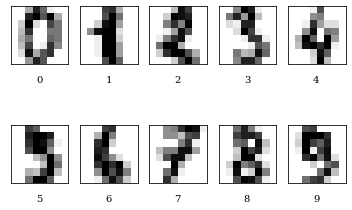

In [573]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)#划分成2行5列
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])#设置坐标轴显示的刻度，此时值为空
    plt.yticks([])
plt.show()

In [574]:
# Split the data into training set and test set 
#train_test_split函数用于将矩阵随机划分为训练子集和测试子集，并返回划分好的训练集测试集样本和训练集测试集标签。
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)#test_size表示样本占比

In [575]:
n_features = X_train.shape[1]
n_hidden = 4
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

In [576]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.
y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [577]:
len(y_train)

1347

In [578]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


In [565]:
def predict(outputNode,graph,X_test,W1,b1,W2,b2):
    X_ = X_test
    W1_ = W1
    b1_ = b1
    W2_ = W2
    b2_ = b2
    
    # Neural network
    X = Input()
    W1, b1 = Input(), Input()
    W2, b2 = Input(), Input()
    l1 = Linear(X, W1, b1)
    s1 = Sigmoid(l1)
    l2 = Linear(s1, W2, b2)
    s2 = Sigmoid(l2)
    
    feed_dict = {
    X: X_test,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
    }
    graph = topological_sort(feed_dict) # build graph
    trainables = [W1, b1, W2, b2] # Trainable parameters
    for n in graph:
        n.forward()
        predict_propability=[]
    for i in s2.value:
        predict_propability+=(i.tolist())
    return predict_propability
list_prediction=(predict(s2,graph,X_test,W1.value,b1.value,W2.value,b2.value))
list_prediction

[0.9575612724599079,
 0.9577475375492482,
 0.034727178707248396,
 0.05270366319254453,
 0.9577475382472446,
 0.9574946561364369,
 0.9577475388328632,
 0.034727178707260484,
 0.06093996662094955,
 0.9577475398115517,
 0.9577475398115517,
 0.05270366319689805,
 0.9577475398110272,
 0.034727178707260484,
 0.9577475398113672,
 0.9577475398115517,
 0.034727178707260484,
 0.9577475398115517,
 0.9577475398115484,
 0.05300272301417674,
 0.9577475381757887,
 0.010272998669628136,
 0.05270366463919189,
 0.03475950233066331,
 0.05270366319265423,
 0.9014478347663315,
 0.9577475398115515,
 0.9577475398115517,
 0.05269991051554236,
 0.05270366319032591,
 0.00010770134748144823,
 0.9577475397391308,
 0.034727178707154166,
 0.9577475398115517,
 0.03472717870726141,
 0.9577475398115517,
 0.9577475398115513,
 0.034727178707260484,
 0.9577475398115515,
 0.9577475398115517,
 0.9577475398115515,
 0.957720522828442,
 0.9577475398072542,
 0.9577475398115513,
 0.9577475398106429,
 0.02829349529002249,
 0.034

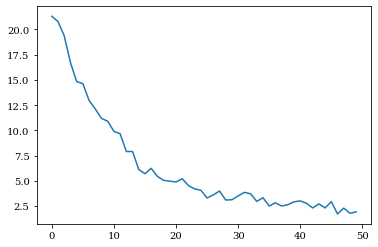

In [566]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)

交叉熵刻画的是通过概率分布q来表达概率分布p的困难程度，其中p是正确答案，q是预测值，也就是交叉熵值越小，两个概率分布越接近

In [567]:
import math
# Write a function that takes as input two lists Y, P,
# and returns the float corresponding to their cross-entropy.
def cross_entropy(Y, P):
    sum=0.0
    for x in map(lambda y,p:(1-y)*math.log(1-p)+y*math.log(p),Y,P):
        sum+=x
    return -sum/len(Y)

cross_entropy(y_test,list_prediction)

0.18880100482450757

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as 0 if the digit < 5 or 1 if the digit >= 5
    - each image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

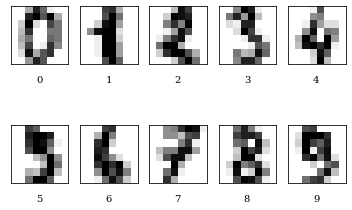

In [600]:
# Loading the data 
digits = datasets.load_digits()
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)#划分成2行5列
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])#设置坐标轴显示的刻度，此时值为空
    plt.yticks([])
plt.show()
# Split the data into training set and test set 
#train_test_split函数用于将矩阵随机划分为训练子集和测试子集，并返回划分好的训练集测试集样本和训练集测试集标签。
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)#test_size表示样本占比
X_train = X_train/255
X_test = X_test/255
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.
y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#### 3- Architecture of the neural network

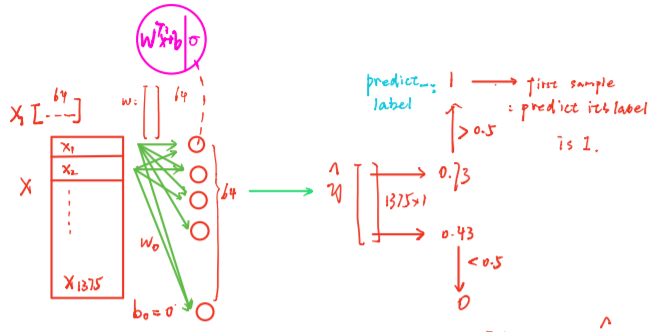

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [481]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1/(1 + np.exp(-1 * z))
    
    return s

In [482]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [483]:
# Random innitialize the parameters
import random
def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    w = np.random.randn(dim, 1)
    b = 0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [484]:
initialize_parameters(10)

(array([[-0.43955868],
        [-2.04248664],
        [-0.42548599],
        [ 0.23056788],
        [-0.44953282],
        [-1.15795471],
        [ 0.87678609],
        [ 0.10697312],
        [-1.68489224],
        [ 0.36694584]]), 0)

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [499]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[0]
    A = sigmoid(np.dot(X,w)+b)
    y_i=Y.reshape(-1,1) 
    cost = -1 * np.sum(y_i * np.log(A)+(1 - y_i) * np.log(1-A)) / m 
    dw = np.dot(X.T,(A-Y)) / m
    db = np.sum(A-y_i) / m
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [486]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [487]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]
    Y_prediction = np.zeros((m,1),dtype=np.int)
    A = sigmoid(np.dot(X,w)+b)
    for i in range(A.shape[0]):
        if A[i,0]>0.5:
            Y_prediction[i,0] = 1
    
    assert(Y_prediction.shape == (m,1))
    return Y_prediction

In [488]:
def calculater_accuracy(prediction,truth):
    accuracy = sum(prediction==truth)/truth.shape[0]   
    return accuracy

In [496]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    w,b=initialize_parameters(X_train.shape[1])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate,print_cost)
    w=params['w']
    b=params['b']

    Y_train_prediction=predict(w,b,X_train)
    traing_accuracy=calculater_accuracy(Y_train_prediction,Y_train)
    Y_test_prediction=predict(w,b,X_test)
    test_accuracy=calculater_accuracy(Y_test_prediction,Y_test)
    d = {"w":w,"b":b,"training_accuracy": traing_accuracy,"test_accuracy":test_accuracy,"cost":costs}
    return d    

##### 5- Merge all functions into a model

In [551]:
get_model=model(X_train, y_train, X_test, y_test, num_iterations=15000, learning_rate=1e-1,print_cost=False)
get_model['w'][0]

array([2.24260083])

In [552]:
print("Training accuracy: "+str(get_model['training_accuracy'][0]))
print("Test accuracy: "+str(get_model['test_accuracy'][0]))

Training accuracy: 0.8396436525612472
Test accuracy: 0.8266666666666667


Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the learning process.   
Hits: plot the learning curve with different learning rate

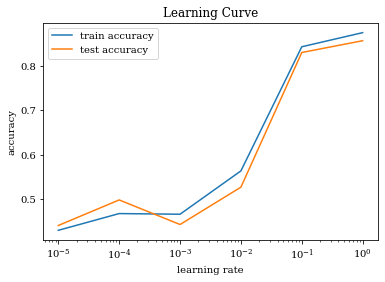

In [553]:
import matplotlib.pyplot as plt
%matplotlib inline
lrs = np.logspace(-5, 0, 6)
test_acc_dict, train_acc_dict = [], []
for lr in lrs:
    d = model(X_train, y_train, X_test, y_test, num_iterations=15000, learning_rate=lr,print_cost=False)
    train_acc_dict.append(d['training_accuracy'])
    test_acc_dict.append(d['test_accuracy'])
fig, ax = plt.subplots()
ax.set_xscale('log')#Set the x-axis to log
ax.plot(lrs, train_acc_dict, label='train accuracy')
ax.plot(lrs, test_acc_dict, label='test accuracy')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.title('Learning Curve')
ax.legend()# add plot

当学习率大于10^-4时，train accuracy和test accuray开始提高；
在学习率在0.01左右时，train accuracy和test accuray最高。

##### 4.2 Observe the effect of iteration_num on the test accuracy.

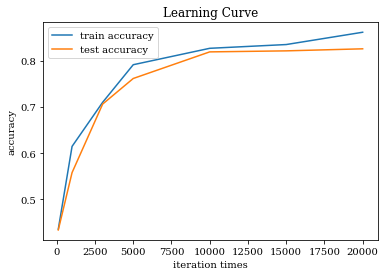

In [556]:
iters = [100,1000,3000, 5000,10000,15000,20000]
train_acc_dict, test_acc_dict = [], []
for num in iters:
    d = model(X_train, y_train, X_test, y_test, num_iterations=int(num), learning_rate=1e-1,print_cost=False)
    train_acc_dict.append(d['training_accuracy'])
    test_acc_dict.append(d['test_accuracy'])
fig, ax = plt.subplots()
ax.plot(iters, train_acc_dict, label='train accuracy')
ax.plot(iters, test_acc_dict, label='test accuracy')
plt.xlabel('iteration times')
plt.ylabel('accuracy')
plt.title('Learning Curve')
ax.legend()

1.当迭代次数超过5000时，training accuracy和test accuracy都会保持在很高的百分比（接近80%）。
2.随着迭代次数的继续增加，training accuracy和test accuracy不会有太大变化。
3.training accuracy在一般情况下高于test accuracy。

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

In [733]:
# process data 
digits = datasets.load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)
# X_train=X_train/255
# X_test=X_test/255
label_numbers=len(set(y_train))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
# def MaxMinNormalization(x):
#     x = (x - x.min()) / (x.max() - x.min());
#     return x
# MaxMinNormalization(X_train)
# MaxMinNormalization(X_test)

In [734]:
# Building the algorithm
import numpy as np
def softmax(x):
    x = x - x.max(axis=1, keepdims=True) # Prevent from appearing nan on cost
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

# Initializaing parameters
def initialize_parameters_using_softmax(dim,label_numbers):
    w = np.random.randn(dim,label_numbers)
    b = 0
    assert(w.shape == (dim,label_numbers))
    assert(isinstance(b,float) or isinstance(b,int))
    return w,b

def one_hot(y,label_numbers):
    m = y.shape[0]
    y_one_hot = np.zeros((m,label_numbers))
    for i in range(m):
        y_one_hot[i,y[i,0]] = 1
    return y_one_hot

# In multi-classification problems, we often use cross entropy as a loss function
def cross_entropy(A, y):
    m = A.shape[0]
    loss = 0
    for i, y_i in enumerate(y):
        loss += -np.log(A[i,y_i])
    return loss / m

# Forward and backward propagation
def propagate_using_softmax(w,b,X,Y):
    m = X.shape[0]
    A = softmax(np.dot(X,w) + b)
    Y_one_hot = one_hot(Y,w.shape[1])
    cost = cross_entropy(A, Y) 
    assert Y_onehot.shape == A.shape
    dw = np.dot(X.T,(A-Y_one_hot)) / m
    db = np.sum(A-Y_one_hot, axis=0) / m   
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {'dw':dw,
             'db':db}
    return grads, cost

def optimize_using_softmax(w, b, X, Y, num_iterations, lr, print_cost=False):
    costs = []    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)       
        dw = grads['dw']
        db = grads['db']      
        w = w - lr * dw
        b = b - lr * db    

        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))   
    params = {"w":w,
              "b":b}    
    grads = {"dw":dw,
             "db":db}
    return params, grads, costs

def predict_using_softmax(w, b, X):
    A = softmax(X.dot(w) + b)
    Y_prediction = A.argmax(axis=1)   
    return Y_prediction.reshape(-1,1)

def calculater_accuracy(prediction,truth):
    accuracy = sum(prediction==truth)/truth.shape[0]   
    return accuracy

def model_using_softmax(X_train, Y_train, X_test, Y_test,label_numbers,num_iterations,learning_rate,print_cost):
    w, b = initialize_parameters_using_softmax(X_train.shape[1],label_numbers)
    params, grads, costs = optimize_using_softmax(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
    
    Y_train_prediction = predict_using_softmax(w, b, X_train)
    training_accuracy = calculater_accuracy(Y_train_prediction,Y_train)
    Y_test_prediction = predict_using_softmax(w, b, X_test)
    test_accuracy = calculater_accuracy(Y_test_prediction,Y_test)
    d = {"w":w,
         "b":b,
         "training_accuracy": training_accuracy,
         "test_accuracy":test_accuracy,
         "costs":costs}
    return d

In [737]:
get_model = model_using_softmax(X_train, y_train, X_test, y_test,label_numbers=label_numbers, num_iterations=15000, learning_rate=1e-1,print_cost=True)
get_model

Cost after iteration 0: 109.117257
Cost after iteration 100: 104.501973
Cost after iteration 200: 100.341842
Cost after iteration 300: 96.614559
Cost after iteration 400: 93.234846
Cost after iteration 500: 90.204020
Cost after iteration 600: 87.489041
Cost after iteration 700: 85.005828
Cost after iteration 800: 82.773241
Cost after iteration 900: 80.768194
Cost after iteration 1000: 78.995775
Cost after iteration 1100: 77.442012
Cost after iteration 1200: 76.062383
Cost after iteration 1300: 74.810096
Cost after iteration 1400: 73.656570
Cost after iteration 1500: 72.594687
Cost after iteration 1600: 71.612702
Cost after iteration 1700: 70.687954
Cost after iteration 1800: 69.807425
Cost after iteration 1900: 68.962962
Cost after iteration 2000: 68.147458
Cost after iteration 2100: 67.356209
Cost after iteration 2200: 66.585950
Cost after iteration 2300: 65.835338
Cost after iteration 2400: 65.103869
Cost after iteration 2500: 64.391426
Cost after iteration 2600: 63.694595
Cost after

{'w': array([[ 7.25827937e-01, -5.71015813e-01, -1.11149205e+00,
         -6.19666466e-01, -2.20062518e+00, -1.70273987e-01,
         -1.02779590e-01,  1.09427588e+00,  1.57778684e+00,
         -2.22541416e-01],
        [ 1.88249496e+03,  1.88292488e+03,  1.88442784e+03,
          1.88253420e+03,  1.88251283e+03,  1.88363777e+03,
          1.88425725e+03,  1.88336519e+03,  1.88333397e+03,
          1.88294229e+03],
        [ 3.47692259e+04,  3.47701623e+04,  3.47673906e+04,
          3.47690285e+04,  3.47693342e+04,  3.47690662e+04,
          3.47696450e+04,  3.47689467e+04,  3.47711685e+04,
          3.47698359e+04],
        [ 7.94103848e+04,  7.94075689e+04,  7.94089007e+04,
          7.94087238e+04,  7.94074139e+04,  7.94084734e+04,
          7.94082773e+04,  7.94088745e+04,  7.94087334e+04,
          7.94087869e+04],
        [ 8.21097590e+04,  8.21102214e+04,  8.21093630e+04,
          8.21086896e+04,  8.21109987e+04,  8.21095194e+04,
          8.21100151e+04,  8.21097960e+04,  8.2

In [738]:
print("Training accuracy: "+str(get_model['training_accuracy'][0]))
print("Test accuracy: "+str(get_model['test_accuracy'][0]))

Training accuracy: 0.09131403118040089
Test accuracy: 0.08444444444444445
